In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import re
from scipy.stats import t as t_dist
from numpy.random import RandomState

from bids import BIDSLayout

from sklearn.model_selection import cross_val_score, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from util.decoding.gee import GEEEstimator
from mne_ari import all_resolutions_inference
from mne.decoding import (
    cross_val_multiscore, 
    LinearModel,                  
    SlidingEstimator, 
    get_coef
)
from mne import set_config
set_config('MNE_MEMMAP_MIN_SIZE', '1M')
set_config('MNE_CACHE_DIR', '.tmp')
import mne

In [2]:
# hard-coded values
BIDS_ROOT = 'bids'
DERIV_ROOT = os.path.join(BIDS_ROOT, 'derivatives')
AGGREGATE_CHOICE = True # if true, does market-level decoding,
                    # but individual choice decoding if false

In [3]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subjects = layout.get_subjects(scope = 'preprocessing')
subjects.sort()
task = layout.get_tasks()[0]

/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [4]:
def load_subj_data(layout, sub):
    
    epochs_fpath = layout.get(
        scope = 'preprocessing', 
        subject = sub, 
        desc = 'clean', 
        extension = 'fif.gz', 
        return_type = 'filename')[0]
    epochs = mne.read_epochs(epochs_fpath, preload = True, verbose = False)
    downsample_fs = 2 * epochs.info['lowpass']
    
    epochs.resample(downsample_fs)
    epochs = epochs.crop(-.1, .7)
    
    events_fpath = layout.get(
        scope = 'raw', 
        subject = sub, 
        suffix = 'events', 
        extension = 'tsv', 
        return_type = 'filename')[0]
    events_df = pd.read_csv(events_fpath, sep = '\t')
    funded = events_df.funded[epochs.selection].to_numpy()
    choice = events_df.choice[epochs.selection].to_numpy()
    stims = events_df.project_id[epochs.selection].to_numpy()
    
    X = epochs.get_data()
    
    return epochs, X, funded, choice, stims


all_X = []
all_fund = []
all_choice = []
all_stims = []
all_subs = []
evs = []

for sub in subjects:
    
    if sub in ['110', '114']: # no visible P1 compenent 
        continue
    
    epochs, X, funded, choice, stims = load_subj_data(layout, sub)
    all_X.append(X)
    all_fund.append(funded)
    all_choice.append(choice)
    all_stims.append(stims)
    all_subs.append(np.repeat(sub, funded.shape[0]))
    evs.append(epochs.average())
    
X = np.concatenate(all_X)
funded = np.concatenate(all_fund)
choice = np.concatenate(all_choice)
stims = np.concatenate(all_stims)
stims = LabelEncoder().fit_transform(stims)
subs = np.concatenate(all_subs)
subs = LabelEncoder().fit_transform(subs)

if AGGREGATE_CHOICE:
    y = funded
else:
    # trials for which subjects actually made a choice (didn't time out)
    idx = np.isfinite(choice)
    X = X[idx]
    subs = subs[idx]
    stims = stims[idx]
    y = choice[idx]


In [5]:
def ttest_1samp_kx2cv(scores, chance = 0.5):
    '''
    Input: list of k (2, n_tests) arrays of scores obtained from
            a series of k different 2-fold cross validation splits
            
    Output: t-values, p-values, and standard errors from 
            a kx2 t-test for classification metrics with null
            hypothesis that metric == 0.5. These are all
            (n_tests,) arrays. Test described in [1].
            
    References
    ----------
    [1] Dietterich TG (1998) Approximate Statistical Tests for 
        Comparing Supervised Classification Learning Algorithms.
        Neural Comput 10:1895–1923.
    '''
    from scipy.stats import t as t_dist
    above_chance = [(scrs - chance) for scrs in scores]
    if above_chance[0].ndim == 1:
        above_chance = [ac[:, np.newaxis] for ac in above_chance]
    # estimate standard error from all the splits
    s2 = [np.square(scrs - scrs.mean(0)).sum(0) for scrs in above_chance]
    s2 = np.stack(s2, axis = 0)
    # but only use first split for observed value since scores on CV splits
    p1 = above_chance[0][0, :] # are not truly independent of one another.
    se = np.sqrt(s2.mean(0)) # see [1]
    # after that, it's just a normal t-test
    t = p1 / se
    p = t_dist.sf(t, df = s2.shape[0]) # one-sided p-value 
    return t, p, (p1 + chance), se

In [6]:
def get_out_of_sample(clf, X, y, stims, subs, seed):
    cv = StratifiedGroupKFold(2, shuffle = True, random_state = seed)
    cv_gen = cv.split(X, y, stims)
    out = []
    for train, test in cv_gen:
        optim_params = dict()
        if not AGGREGATE_CHOICE:
            optim_params = dict(maxiter = 100, first_dep_update = 20, params_niter = 10)
        clf.fit(X[train], y[train], groups = subs[train], **optim_params)
        y_hat = clf.predict_proba(X[test])[...,1]
        y_test = y[test]
        y_both = (y_test, y_hat)
        out.append(y_both)
    return out

def do_permutations(y_test, y_hat, seed, n_permutations = 10000):
    rng = RandomState(seed)
    out = []
    for k in range(n_permutations):
        y = y_test.copy()
        if k != 0:
            rng.shuffle(y)
        compute_aucroc = lambda x: roc_auc_score(y, x)
        aucroc = np.apply_along_axis(compute_aucroc, 0, y_hat)
        out.append(aucroc)
    return np.stack(out, axis = 0)

def _get_permutation_dist(clf, X, y, stims, subs, seed):
    ys = get_out_of_sample(clf, X, y, stims, subs, seed) 
    H0_0 = do_permutations(ys[0][0], ys[0][1], seed)
    H0_1 = do_permutations(ys[1][0], ys[1][1], seed)
    return np.stack([H0_0, H0_1])

def get_permutation_dist(clf, X, y, stims, subs, seed):
    fit = False
    while not fit:
        try:
            out = _get_permutation_dist(clf, X, y, stims, subs, seed)
            fit = True
        except: # if model failed due to random init,
            rng = RandomState(seed) # then try again with new seed
            seed = rng.randint(1, np.iinfo(np.int32).max - 1, 1)[0]
    return out

logistic_reg = GEEEstimator(family = 'binomial', cov_type = 'naive')
clf = LinearModel(logistic_reg)
time_decod = SlidingEstimator(clf, n_jobs = 1, scoring = 'roc_auc', verbose = True)

from mne.parallel import parallel_func
parallel, p_func, _ = parallel_func(get_permutation_dist, 5)
out = parallel(
    p_func(time_decod, X, y, stims, subs, seed) 
    for seed in range(10)
)
t, _, _, _ = ttest_1samp_kx2cv(out) # permutation distribution of t-stat

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
 48%|████▊     | Fitting SlidingEstimator : 39/81 [00:14<00:14,    2.83it/s]/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1251: IterationLimitWarning: Iteration limit reached prior to convergence
  warnings.warn("Iteration limit reached prior to convergence",
100%|██████████| Fitting SlidingEstimator : 81/81 [00:29<00:00,    2.75it/s]
100%|██████████| Transforming SlidingEstimator : 81/81 [00:00<00:00,  317.02it/s]
100%|██████████| Fitting SlidingEstimator : 81/81 [00:29<00:00,    2.72it/s]
100%|██████████| Transforming SlidingEstimator : 81/81 [00:00<00:00,  341.02it/s]
100%|██████████| Fitting SlidingEstimator : 81/81 [00:30<00:00,    2.64it/s]
100%|██████████| Transforming SlidingEstimator : 81/81 [00:00<00:00,  338.64it/s]
100%|██████████| Fitting SlidingEstimator : 81/81 [00:31<00:00,    2.60it/s]
100%|██████████| Transforming 

In [7]:
param_thres = t_dist.ppf(.95, df = 10) # parametric rejection threshold

# compute corrected rejection threshold by t-max
tmax = t.max(1) # max stat across all tests, on each permutation
tmax_thres = np.quantile(tmax, .95) # rejection threshold

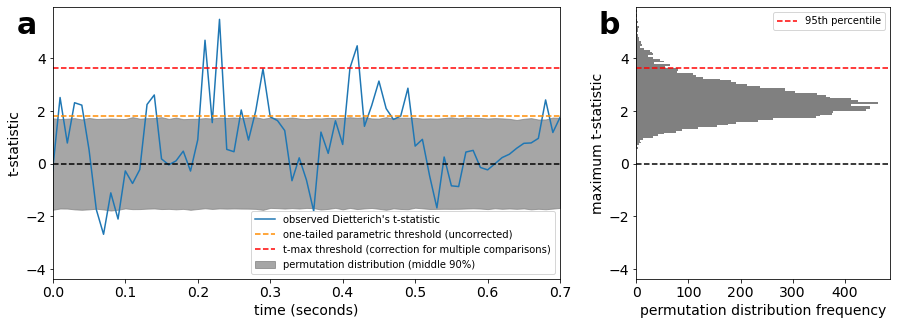

In [8]:
mpl.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(
    1, 2, figsize = (15, 5),
    gridspec_kw = {'width_ratios': [2, 1]}
)

axs[0].plot(epochs.times, t[0], label = "observed Dietterich's t-statistic")
upper = np.quantile(t, .95, axis = 0)
lower = np.quantile(t, .05, axis = 0)
axs[0].fill_between(
        epochs.times, 
        upper, lower, 
        color = 'gray', 
        alpha = .7, 
        label = 'permutation distribution (middle 90%)'
    )
axs[0].axhline(0, color = 'black', linestyle = '--')
axs[0].axhline(
    param_thres, color = 'darkorange', linestyle = '--', 
    label = 'one-tailed parametric threshold (uncorrected)'
)
axs[0].axhline(
    tmax_thres, color = 'red', linestyle = '--', 
    label = 't-max threshold (correction for multiple comparisons)'
)
axs[0].set_xlim(0, epochs.times[-1])
axs[0].set_xlabel('time (seconds)')
axs[0].set_ylabel('t-statistic')
axs[0].legend(prop={'size': 10})
axs[0].text(-.05, axs[0].get_ylim()[1] - 1, 'a', size = 30, weight = 'bold')

axs[1].hist(tmax, bins = 100, orientation = 'horizontal', color = 'gray')
axs[1].set_ylim(*axs[0].axes.get_ylim())
axs[1].axhline(0, color = 'black', linestyle = '--')
axs[1].axhline(tmax_thres, color = 'red', linestyle = '--', label = '95th percentile')
axs[1].set_ylabel('maximum t-statistic')
axs[1].set_xlabel('permutation distribution frequency')
axs[1].legend(prop={'size': 10})
low, up = axs[1].get_xlim()
axs[1].text(-.15*up, axs[0].get_ylim()[1] - 1, 'b', size = 30, weight = 'bold')

if AGGREGATE_CHOICE:
    fname = 'permutation-funded.jpeg'
else:
    fname = 'permutation-choice.jpeg'

plt.savefig(fname, dpi = 500)
plt.show()

In [9]:
# windows in which market prediction was significant in main analysis
sig_idxs = np.array([31, 33, 52])
epochs.times[sig_idxs]

array([0.21, 0.23, 0.42])

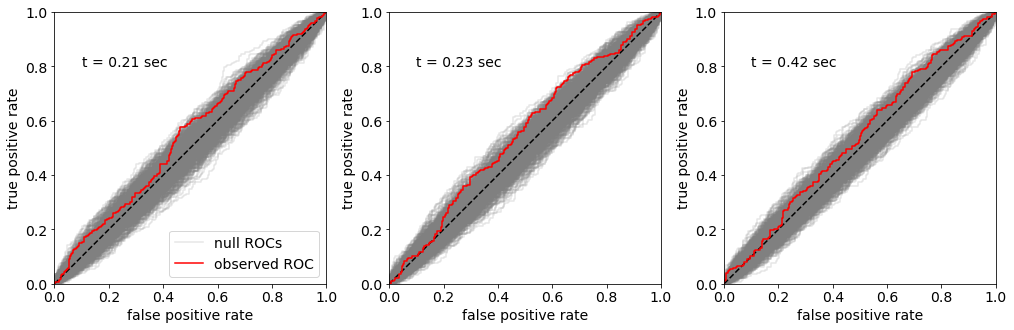

In [10]:
def plot_roc_curve(idx, ax, legend = False):
    
    from sklearn.metrics import roc_curve
    from seaborn import move_legend
    
    logistic_reg = GEEEstimator(family = 'binomial', cov_type = 'naive')
    out = get_out_of_sample(logistic_reg, X[:,:,idx], y, stims, subs, 0)

    fprs = []
    tprs = []
    for k in range(1000):
        _y, yhat = out[0]
        if k != 0:
            _y = _y.copy()
            np.random.shuffle(_y)
        fpr, tpr, _ = roc_curve(_y, yhat)
        fprs.append(fpr)
        tprs.append(tpr) 
        
        
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_box_aspect(1)
    for i in range(len(fprs)):
        if i == 0:
            ax.plot(fprs[i], tprs[i], alpha = .2, color = 'gray', label = 'null ROCs')
        else:
            ax.plot(fprs[i], tprs[i], alpha = .2, color = 'gray')
    ax.axline((0, 0), (1, 1), color = 'black', linestyle = '--')
    ax.plot(fprs[0], tprs[0], color = 'red', label = 'observed ROC')
    ax.text(.1, .8, 't = %.02f sec'%epochs.times[idx])
    if legend:
        ax.legend()
        move_legend(ax, 'lower right')
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    
np.random.seed(0)
fig, axs = plt.subplots(1, sig_idxs.size, figsize = (17,5))
for i in range(sig_idxs.size):
    include_legend = (i == 0)
    plot_roc_curve(sig_idxs[i], axs[i], include_legend)
if AGGREGATE_CHOICE:
    fname = 'roc-funded.jpeg'
else:
    fname = 'roc-choice.jpeg'
plt.savefig(fname, dpi = 500)
plt.show()